# Some recommendations

### 1. This session relates to **Mathematitics** and pioneers of **Calculus**

In [1]:
!cat ./example_visited/previously_seen1.txt

https://en.wikipedia.org/wiki/Leonhard_Euler
https://en.wikipedia.org/wiki/Isaac_Newton
https://en.wikipedia.org/wiki/Mathematics
https://en.wikipedia.org/wiki/Functions_(mathematics)
https://en.wikipedia.org/wiki/Real_number




In [2]:
!python recommender.py 5 ./example_visited/previously_seen1.txt

https://en.wikipedia.org/wiki/Leonhard_Euler not found in the database. Calculating document vector...
https://en.wikipedia.org/wiki/Isaac_Newton not found in the database. Calculating document vector...
Recommended documents:
(240, 'https://en.wikipedia.org/wiki/Hyperreal_numbers', 'Hyperreal number')
Cosine similarity: 0.06210137608606608

(258, 'https://en.wikipedia.org/wiki/Theorem', 'Theorem')
Cosine similarity: 0.0590626066522234

(79, 'https://en.wikipedia.org/wiki/Calculus', 'Calculus')
Cosine similarity: 0.054672164284898996

(322, 'https://en.wikipedia.org/wiki/Bijective', 'Bijection')
Cosine similarity: 0.05021229255088811

(184, 'https://en.wikipedia.org/wiki/Mathematical_analysis', 'Mathematical analysis')
Cosine similarity: 0.04862576791724621



We see topics we would expect for someone interested in **Newton** and **Euler** and **Mathematics**

### 2. This session relates sandwiches

In [3]:
!cat ./example_visited/previously_seen2.txt

https://en.wikipedia.org/wiki/Peanut_butter
https://en.wikipedia.org/wiki/Lunch
https://en.wikipedia.org/wiki/Sandwich


In [4]:
!python recommender.py 5 ./example_visited/previously_seen2.txt

Recommended documents:
(560, 'https://en.wikipedia.org/wiki/Bal%C4%B1k_ekmek', 'Balık ekmek')
Cosine similarity: 0.23502137689424202

(605, 'https://en.wikipedia.org/wiki/Roujiamo', 'Roujiamo')
Cosine similarity: 0.20909613026041712

(599, 'https://en.wikipedia.org/wiki/Panini_(sandwich)', 'Panini (sandwich)')
Cosine similarity: 0.19268899828898028

(583, 'https://en.wikipedia.org/wiki/Donkey_burger', 'Donkey burger')
Cosine similarity: 0.19119226566432948

(800, 'https://en.wikipedia.org/wiki/Bag_lunch', 'Packed lunch')
Cosine similarity: 0.18548005955094318



Indeed, we see different types of sandwiches someone could be interested in

# Some statistics and exploration of the results

In [5]:
import matplotlib.pyplot as plt
from indexing import SqliteInvertedIndex
import recommender
from recommender import jacard_similarity, cosine_similarity
import numpy as np

In [6]:
inverted_index = SqliteInvertedIndex("inverted_index.db")
inverted_index_matrix = inverted_index.get_tf_idf_matrix()

query = lambda query_text: inverted_index.cursor.execute(query_text)

## Number of documents

In [7]:
query("select count(*) from documents").fetchone()

(1000,)

### Number of terms

In [8]:
query("select count(*) from terms").fetchone()

(116470,)

### Top 20 frequently occuring terms 

In [9]:
res = query(
    """
    select term, sum(count) 
    from postings p 
    join terms t on p.term_id = t.id 
    group by term 
    having length(term) > 3 
    order by sum(count) desc
    limit 10
            """
)
res.fetchall()

[('shrew', 32304),
 ('function', 14177),
 ('retrieved', 12128),
 ('edit', 11623),
 ('space', 8069),
 ('isbn', 7562),
 ('also', 7100),
 ('archived', 6817),
 ('original', 6753),
 ('number', 6483)]

Despite weirdness of _shrew_, and manually checking, it turns out that _shrew_ __indeed is__ a frequent word in the documents related to mammals and other animals

### Terms with lowest entropy

In [10]:
query(
    """
        select term, idf from terms order by idf asc limit 10
        """
).fetchall()

[('retrieved', 0.0),
 ('http', 0.0),
 ('1', 0.022245608947319737),
 ('reference', 0.03978087001184446),
 ('edit', 0.06935007813479324),
 ('2', 0.08773891430800689),
 ('also', 0.1266976530459575),
 ('3', 0.1636960926707897),
 ('see', 0.1779312084926618),
 ('new', 0.18632957819149354)]

### Terms with highest entropy

In [11]:
query(
    """
  select term, idf from terms order by idf desc limit 10
  """
).fetchall()

[('combable', 6.907755278982137),
 ('ℝ3', 6.907755278982137),
 ('idealizes', 6.907755278982137),
 ('meteorologically', 6.907755278982137),
 ('accomplishes', 6.907755278982137),
 ('gidea', 6.907755278982137),
 ('1584882530', 6.907755278982137),
 ('abbildung', 6.907755278982137),
 ('bormashenko', 6.907755278982137),
 ('kazachkov', 6.907755278982137)]

### Distribution of terms occurance among all documents

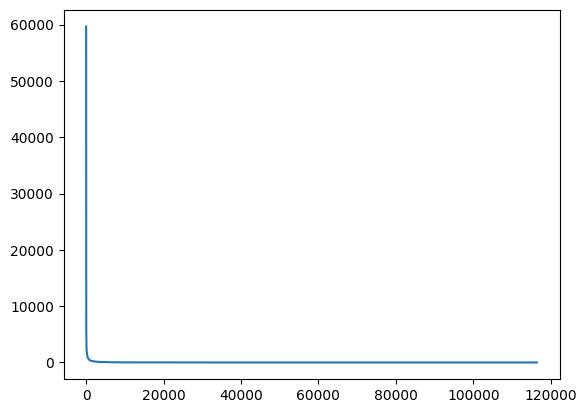

In [12]:
res = query(
    """
        select t.term, sum(p.count) 
        from terms t join postings p on t.id = p.term_id 
        group by t.term
        order by sum(p.count) desc
    """
).fetchall()

plt.plot([x[1] for x in res])

### Checking if corpus fulfills Zipf's law

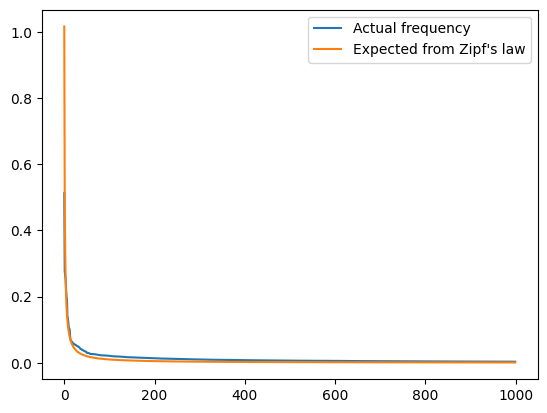

In [13]:
res = query(
    """
    select t.term, sum(p.count)
    from terms t join postings p on t.id = p.term_id
    group by t.term
    order by sum(p.count) desc
    """
).fetchall()

ocurrances = np.array([x[1] for x in res])
N = len(ocurrances)
k = ocurrances[3] / N * 4
expected_zipf = k / np.arange(1, N + 1)

cut_off = 1000
plt.plot(ocurrances[:1000] / N)
plt.plot(expected_zipf[:1000])
plt.legend(["Actual frequency", "Expected from Zipf's law"])

### Documents most similar to the article **Open Set**

In [14]:
url = "https://en.wikipedia.org/wiki/Open_set"
doc_id = inverted_index.get_document_id(url)
assert doc_id is not None

doc_vector = inverted_index_matrix[doc_id, :]

similarities = np.apply_along_axis(
    lambda x: cosine_similarity(doc_vector, x), 1, inverted_index_matrix
)

top_5_similarities = np.argsort(similarities, axis=0)[-6:-1]

for doc_id in top_5_similarities[::-1]:
    res = query(
        f"""
        select title from documents where id = {doc_id}
        """,
    ).fetchone()
    assert res is not None
    print(f"Title: {res[0]}")
    print(f"Cosine similarity: {similarities[doc_id]}\n")

Title: Open set
Cosine similarity: 1.0

Title: Closed set
Cosine similarity: 0.1670939050012435

Title: Accumulation point
Cosine similarity: 0.09399570728349808

Title: Open and closed maps
Cosine similarity: 0.09323925622985396

Title: Open and closed maps
Cosine similarity: 0.09323925622985396



### Documents least similar document to the article **Open set**

In [15]:
url = "https://en.wikipedia.org/wiki/Open_set"
doc_id = inverted_index.get_document_id(url)
assert doc_id is not None

doc_vector = inverted_index_matrix[doc_id, :]

similarities = np.apply_along_axis(
    lambda x: cosine_similarity(doc_vector, x), 1, inverted_index_matrix
)

top_5_similarities = np.argsort(similarities, axis=0)[:5]

for doc_id in top_5_similarities:
    res = query(
        f"""
        select title from documents where id = {doc_id}
        """,
    ).fetchone()
    assert res is not None
    print(f"Title: {res[0]}")
    print(f"Cosine similarity: {similarities[doc_id]}\n")

Title: Eastern forest hedgehog
Cosine similarity: 4.099291536117715e-06

Title: Chacarero
Cosine similarity: 1.473436229790874e-05

Title: Somali hedgehog
Cosine similarity: 2.148079406048971e-05

Title: Hemiechinus
Cosine similarity: 2.2237134281189762e-05

Title: Gaoligong forest hedgehog
Cosine similarity: 2.259060627956648e-05



These results make sense, as Open Set relates to topics like *topology* and *closed sets*, while do not relate to topics like *hedgehogs* or *Chacarero*

**Open Set**:

![Open Set](./reports/imgs/open-set.png)

**Closed Set** (similar to Open Set):

![Closed Set](./reports/imgs/closed-set.png)

**Eastern forest hedgehog** (not similar to Open Set):

![Eastern forest hedgehog](./reports/imgs/eastern-forest-hedgehog.jpeg)

# Comparing similiarities between various documents 

In [16]:
hedghog_doc_url = "https://en.wikipedia.org/wiki/Hedgehog"
hedgehog_doc_id = inverted_index.get_document_id(hedghog_doc_url)
hedgehog_doc_vector = inverted_index_matrix[hedgehog_doc_id, :]
assert hedgehog_doc_vector is not None

calculus_doc_url = "https://en.wikipedia.org/wiki/Calculus"
calculus_doc_id = inverted_index.get_document_id(calculus_doc_url)
calculus_doc_vector = inverted_index_matrix[calculus_doc_id, :]
assert calculus_doc_vector is not None

derivatives_doc_url = "https://en.wikipedia.org/wiki/Derivative"
derivatives_doc_id = inverted_index.get_document_id(derivatives_doc_url)
derivatives_doc_vector = inverted_index_matrix[derivatives_doc_id, :]
assert derivatives_doc_vector is not None

### Cosine similarity and Jacard similarity between hedgehog and calculus 

In [17]:
cosine_similarity_score = cosine_similarity(hedgehog_doc_vector, calculus_doc_vector)
jacard_similarity_score = jacard_similarity(hedgehog_doc_vector, calculus_doc_vector)

print("Hedgehog vs Calculus")
print(f"Cosine similarity: {cosine_similarity_score}")
print(f"Jacard similarity: {jacard_similarity_score}")

Hedgehog vs Calculus
Cosine similarity: 0.0036931801887427344
Jacard similarity: 0.09270638525247128


### Cosine similarity and Jacard similarity between calculus and derivatives

In [18]:
cosine_similarity_score = cosine_similarity(calculus_doc_vector, derivatives_doc_vector)
jacard_similarity_score = jacard_similarity(calculus_doc_vector, derivatives_doc_vector)
print("Calculus vs Derivatives")
print(f"Cosine similarity: {cosine_similarity_score}")
print(f"Jacard similarity: {jacard_similarity_score}")

Calculus vs Derivatives
Cosine similarity: 0.04768521737485992
Jacard similarity: 0.27093206951026855


Cosine similarity between derivatives and hedgehog is almost **two order of magnitude higher** than the cosine similarity between hedgehog and calculus, what should be expected

### The results and the quality of recommender would be higher for more documents than only 1000. To increase this number, before building the DB one could change `TOTAL_PAGES` in [`build_db.py`](https://github.com/shhhQuiettt/wikipedia-search-engine/blob/main/build_db.py)